<center><h1>Mini Project 1</h1></center>
<hr />

# Part A: Original feature space and Euclidean distance

Given the dataset with four-classes (you can download from the [link](http://vigir.ee.missouri.edu/~gdesouza/ece7720/Homework/data_class4.mat) provided on Canvas as .mat) where each class follows a specific distribution:

In [126]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import pi

In [127]:
mat = loadmat(os.path.join("data", "data_class4.mat"))
data = mat["Data"][0]

In [128]:
C = data.shape[0]
C

4

In [129]:
D = data[0].shape[0]
D

2

In [130]:
N = np.zeros(C)
for c in range(C):
    N[c] = data[c].shape[1]
print("N", N)

N [400. 400. 600. 400.]


In [131]:
data[0].shape

(2, 400)

- There are 4 classes, $C = 4$ and $c = 1,...,C$.
- Each class has 400 patterns/samples/vectors, $N = 400$.
- Each sample $\vec{x_i}$ is a 2-d vector, $i=1,...,N$.

## 1. Estimate the mean and covariance of each class distribution using a library function (i.e. Matlab toolbox, or Python statistics package, etc.). Report on their values.

### Compute means $\mu$

$$\vec{\mu_c}\mathbf(x) = \frac{1}{N}\sum_{i=1}^{N_c}\vec{x_i}$$

In [132]:
means = []
for c in range(C):
    mu = np.mean(data[c], axis=1)
    means.append(mu)
    print(f"mu {c} = {mu}")
means = np.array(means)

mu 0 = [9.93166666 5.04771704]
mu 1 = [ 6.89476702 -3.06678779]
mu 2 = [-1.96618141 -2.05252646]
mu 3 = [-1.85830966  2.96492564]


### Compute variances $\sigma^2$

$$ \vec{\sigma^2_c}(\mathbf{x}) = \frac{1}{N-ddof} \sum_{i=1}^{N_c}(\vec{x_i}-\vec{\mu_c})^2 $$

- $\sigma^2_c$ is the population variance of class $c$.

Note: `numpy` computes variance depending on *delta degrees of freedom* (ddof). So, in order to compute a sample variance, ddof must be set to 1.

In [133]:
variances = []
for c in range(C):
    var = np.var(data[c], axis=1, ddof=1)
    variances.append(var)
    print(f"variance {c} = {var}")
variances = np.array(variances)

variance 0 = [2.92878667 4.14604723]
variance 1 = [1.90650611 2.03553604]
variance 2 = [6.69513194 1.17354871]
variance 3 = [1.90363212 0.66481358]


In [134]:
# numpy's built-in function for computing covariance matrix

np_covariances = []
for c in range(C):
    cov = np.cov(data[c], ddof=1)
    np_covariances.append(cov)
#     print(f"covariance {c} \n {cov}")
np_covariances = np.array(np_covariances)

In [135]:
# my function for computing covariance matrix (without optimization)

covariances = np.zeros((C, D, D))
for c in range(C):
    for i in range(D):
        for j in range(D):
            cov = np.sum((data[c][i] - means[c][i]) * (data[c][j] - means[c][j])) / (N[c]-1.)
            covariances[c, i, j] = cov
#             print(f"covariance {c} {i} {j} = {cov}")
                
print("covariances\n", covariances)

covariances
 [[[ 2.92878667  1.34060751]
  [ 1.34060751  4.14604723]]

 [[ 1.90650611  1.2951869 ]
  [ 1.2951869   2.03553604]]

 [[ 6.69513194  1.01051255]
  [ 1.01051255  1.17354871]]

 [[ 1.90363212 -0.53673905]
  [-0.53673905  0.66481358]]]


In [136]:
np.sum((data[c][i] - means[c][i])**2) / (N-1)

array([0.66481358, 0.66481358, 0.44283909, 0.66481358])

In [137]:
eigenvalues, eigenvectors = [], []
for c in range(C):
    val, vec = np.linalg.eig(covariances[c])
    eigenvalues.append(val)
    eigenvectors.append(vec)
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

In [138]:
eigenvalues[c]

array([2.10383047, 0.46461523])

In [139]:
covariances[c] - np.identity(D)

array([[ 0.90363212, -0.53673905],
       [-0.53673905, -0.33518642]])

## 2. Plot the data in each of the four classes using different colors and display their eigen-vectors.

## 3. Consider the following four test samples in the table below 1:

| Test Samples | x-value | y-value |
|--------------|---------|---------|
| s1           | 2.3     | 1.9     |
| s2           | 7       | -0.3    |
| s3           | 10      | 0.5     |
| s4           | -1.2    | 0.6     |
<center>Table 1: Test Samples to be classified</center>

### (a) On the same previous plot, display the four test samples.

In [140]:
test_samples = np.array([[2.3, 1.9], [7, -0.3], [10, 0.5], [-1.2, 0.6]])

#### [Ellipse equation](https://math.stackexchange.com/a/2647450)

$$ x(\alpha)=\sigma^2_{c,x} \cos(\alpha)\cos(\theta) − \sigma^2_{c,y} \sin(\alpha)\sin(\theta) + \mu_{c,x} $$
$$ y(\alpha)=\sigma^2_{c,x} \cos(\alpha)\sin(\theta) + \sigma^2_{c,y} \sin(\alpha)\cos(\theta) + \mu_{c,y} $$

- $\theta \in [0, 2\pi]$
- $\alpha \in [0, 2\pi]$ is the rotation radians
- $\sigma^2_{c,d}$ is the variance of class $c$ in dimension $d$
- $\mu_{c,d}$ is the mean of class $c$ in dimension $d$

In [254]:
def visualize_space(data, means, eigenvalues, eigenvectors, title=None, save_name=None, figsize=(10, 9), test_samples=None, test_index=None, distances=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    colors = ["blue", "red", "orange", "green"]
    for c in range(C):
        # patterns
        ax.scatter(data[c][0], data[c][1], color=colors[c], label=f"class {c+1}")
        # mean
        mean_x, mean_y = means[c]
        ax.scatter(mean_x, mean_y, color=colors[c], marker="*", edgecolor="black", s=150, linewidth=2, label=f"mean {c+1}")
        # variance
        theta = np.linspace(0, 2*np.pi, 100)

        major_idx = np.argmax(eigenvalues[c])
        minor_idx = np.argmin(eigenvalues[c])
        alpha = np.arctan2(eigenvectors[c, 1, major_idx], eigenvectors[c, 0, major_idx])
        major_r_x = eigenvalues[c, major_idx]
        major_r_y = eigenvalues[c, minor_idx]
        AXIS_COLORS = ["black", "grey"]
        axis_colors = [AXIS_COLORS[major_idx], AXIS_COLORS[minor_idx]]

        e_X = major_r_x * np.cos(theta) * np.cos(alpha) - major_r_y * np.sin(theta) * np.sin(alpha) + mean_x
        e_Y = major_r_x * np.cos(theta) * np.sin(alpha) + major_r_y * np.sin(theta) * np.cos(alpha) + mean_y
        ax.plot(e_X, e_Y, color="black", linestyle="--")

        ax.plot([mean_x, mean_x+eigenvalues[c, major_idx]*eigenvectors[c, 0, major_idx]], [mean_y, mean_y+eigenvalues[c, major_idx]*eigenvectors[c, 1, major_idx]], linewidth=3, color=axis_colors[0])
        ax.plot([mean_x, mean_x+eigenvalues[c, minor_idx]*eigenvectors[c, 0, minor_idx]], [mean_y, mean_y+eigenvalues[c, minor_idx]*eigenvectors[c, 1, minor_idx]], linewidth=3, color=axis_colors[1])
#         print(np.power((mean_x+eigenvalues[c, major_idx]*eigenvectors[c, 0, major_idx]) - mean_x, 2) + np.power((mean_y+eigenvalues[c, major_idx]*eigenvectors[c, 1, major_idx]) - mean_y, 2))
#         print(np.power((mean_x+eigenvalues[c, minor_idx]*eigenvectors[c, 0, minor_idx]) - mean_x, 2) + np.power((mean_y+eigenvalues[c, minor_idx]*eigenvectors[c, 1, minor_idx]) - mean_y, 2))

    # test samples
    if test_samples is not None:
        ax.scatter(test_samples[:, 0], test_samples[:, 1], color="deeppink", marker="x", label="test samples", edgecolor="black", s=50, linewidth=3)
    # euclidean distance
    if distances is not None:
        s_x, s_y = test_samples[test_index, 0], test_samples[test_index, 1]
        for c in range(C):
            mu_x, mu_y = means[c]
            ax.plot([s_x, mu_x], [s_y, mu_y], linewidth=3, color="plum")
            ax.text((s_x + mu_x) / 2, (s_y + mu_y) / 2, f"{distances[c, j]:.2f}")
        predicted_c = np.argmin(distances[:, test_index])
        ax.plot([s_x, means[predicted_c, 0]], [s_y, means[predicted_c, 1]], linewidth=3, color="darkviolet", label="$\\min ||\\vec \mu_i  - \\vec s_j||_2$")

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Line2D([0], [0], color="black", linewidth=3, linestyle='--'))
    labels.append("$\sigma^2_{c}$")
    
    if distances is not None:
        handles.insert(0, Line2D([0], [0], color="plum", linewidth=3, linestyle='-'))
        labels.insert(0, "$||\\vec \mu_i  - \\vec s_j||_2$")

    plt.legend(handles, labels)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name, dpi=300)

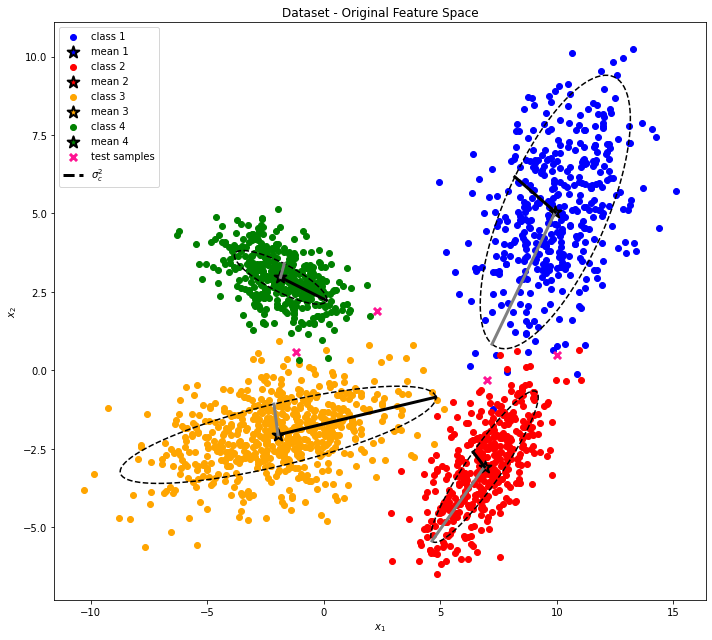

In [255]:
visualize_space(data, means, eigenvalues, eigenvectors, title="Dataset - Original Feature Space", save_name="dataset-original_feature_space.png", test_samples=test_samples) # (10, 7)

### (b) Compute the Euclidean distances d(µi, sj) between the center of each class i = 1, 2, 3, 4 and the test samples j = 1, 2, 3, 4.

$$ d(\mu_i, s_j) = ||\vec{\mu_i} - \vec{s_j}||_2 $$

- $d_{i,c}$ is the distance between center of class $i$ and test sample $j$
- $\vec{s_j}$ is the test sample $j$

In [249]:
J = test_samples.shape[0]
distances = np.zeros((C, J))

def euclidean_distance(x, y):
    return np.sqrt(np.sum(np.power(x - y, 2)))

for c in range(C):
    for j in range(J):
        distances[c, j] = euclidean_distance(means[c], test_samples[j])

distances

array([[ 8.2553291 ,  6.09858565,  4.5482304 , 11.98733454],
       [ 6.76615584,  2.7687883 ,  4.72910637,  8.88653958],
       [ 5.81573462,  9.13585015, 12.23539492,  2.76096551],
       [ 4.29250578,  9.44083627, 12.11178626,  2.45484111]])

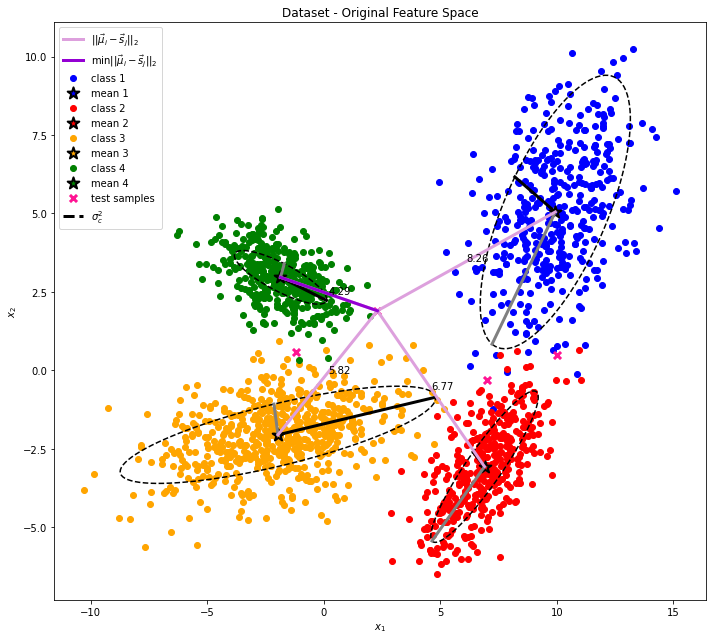

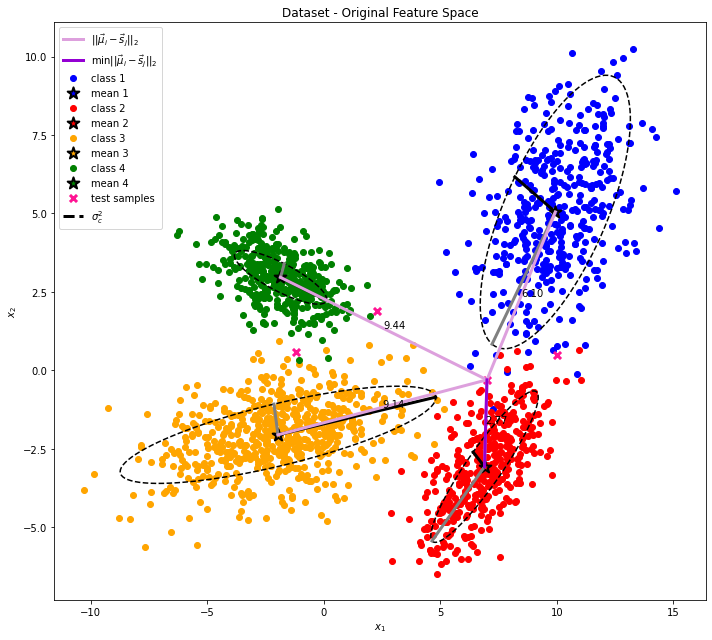

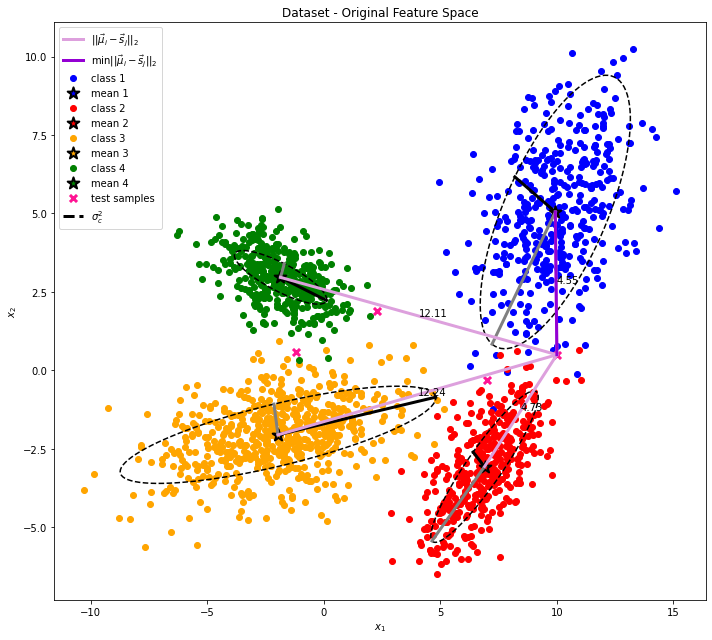

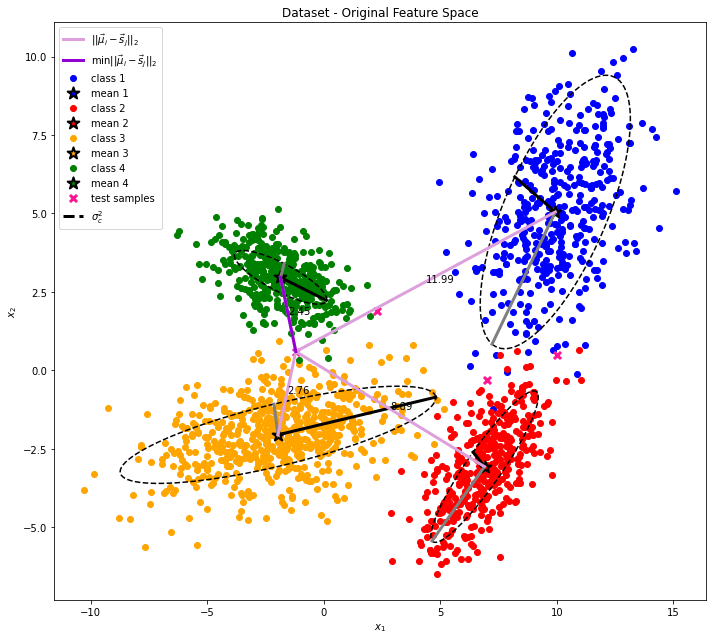

In [252]:
for j in range(J): # each test sample
    visualize_space(data, means, eigenvalues, eigenvectors, title=f"Test sample $s_{j+1}$", save_name=f"test_samples-euclidean_distances-{j+1}.png", test_samples=test_samples, test_index=j, distances=distances) # (10, 7)

In [277]:
# for filling in the report table

def print_report_table(distances):
    for i in range(distances.shape[0]):
        print(f"| s{i+1}", end=" | ")
        for j in range(distances.shape[1]):
            print(f"{distances[i, j]:.4f}", end=" | ")
        print(f"class {np.argmin(distances[i]) + 1}", end=" |")
        print()

print_report_table(distances.T)

| s1 | 8.2553 | 6.7662 | 5.8157 | 4.2925 | class 4 |
| s2 | 6.0986 | 2.7688 | 9.1359 | 9.4408 | class 2 |
| s3 | 4.5482 | 4.7291 | 12.2354 | 12.1118 | class 1 |
| s4 | 11.9873 | 8.8865 | 2.7610 | 2.4548 | class 4 |


### (c) Classify the test samples accordingly and report the results in the following table 2:

| Test Samples | d($\mu_1$,$s_j$) | d($\mu_2$,$s_j$) | d($\mu_3$,$s_j$) | d($\mu_4$,$s_j$) | Class Assignment |
|--------------|-------------:|--:|--:|--:|------------------|
| s1 | 8.2553 | 6.7662 | 5.8157 | 4.2925 | class 4 |
| s2 | 6.0986 | 2.7688 | 9.1359 | 9.4408 | class 2 |
| s3 | 4.5482 | 4.7291 | 12.2354 | 12.1118 | class 1 |
| s4 | 11.9873 | 8.8865 | 2.7610 | 2.4548 | class 4 |
<center>Table 2: Euclidean distances and classification results in the original feature space</center>

<hr />

## Part B: Whitened space and Euclidean distance

### 1. Apply a whitening transformation to the data in each of the classes according to their own parameters (i.e. Mean and Covariance)


#### Whitened mean

$$ \vec{\mu_W}(\mathbf{x}) =  $$



In [222]:
eigenvalue_matrices = np.zeros_like(covariances)
whitened_data = np.zeros_like(data)
whitened_means = np.zeros_like(means)
whitened_covariances = np.zeros_like(covariances)
whitened_eigenvalues = np.zeros_like(eigenvalues)
whitened_eigenvectors = np.zeros_like(eigenvectors)
whitened_test_samples = np.zeros_like(test_samples)

for c in range(C):
    eigenvalue_matrices[c] = np.identity(D) * (1 / np.sqrt(eigenvalues[c]))
    whitened_data[c] = eigenvalue_matrices[c] @ eigenvectors[c].T @ data[c]
    whitened_means[c] = eigenvalue_matrices[c] @ eigenvectors[c].T @ means[c]
    whitened_covariances[c] = eigenvalue_matrices[c] @ eigenvectors[c].T @ covariances[c] @ eigenvectors[c] @ eigenvalue_matrices[c]
    whitened_eigenvalues[c], whitened_eigenvectors[c] = np.linalg.eig(whitened_covariances[c])
    whitened_test_samples[c] = eigenvalue_matrices[c] @ eigenvectors[c].T @ test_samples[c]

#### Whitened covariance

$$ \Sigma_w $$

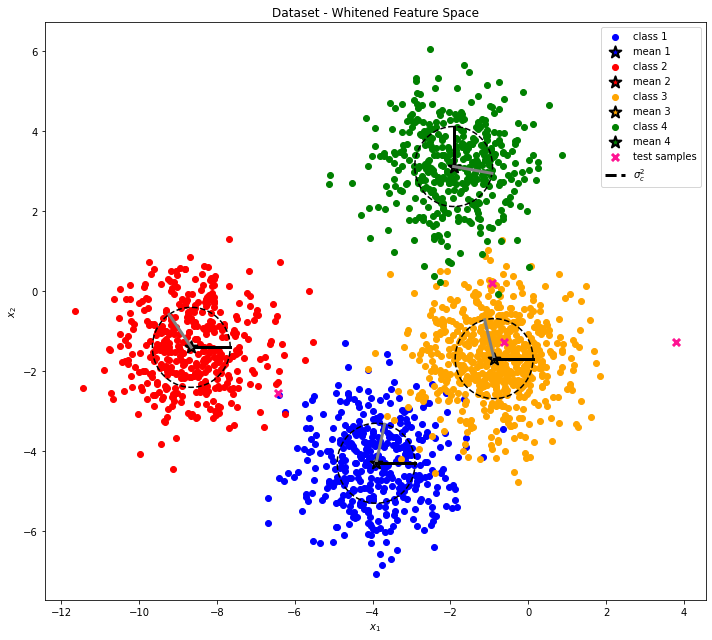

In [253]:
visualize_space(whitened_data, whitened_means, whitened_eigenvalues, whitened_eigenvectors, title="Dataset - Whitened Feature Space", save_name="dataset-whitened_feature_space.png", test_samples=whitened_test_samples)

In [256]:
whitened_distances = np.zeros_like(distances)

for c in range(C):
    for j in range(J):
        whitened_distances[c, j] = euclidean_distance(whitened_means[c], whitened_test_samples[j])

whitened_distances

array([[ 4.4631794 ,  3.06849906,  8.27585108,  5.408641  ],
       [ 8.02945022,  2.50838516, 12.44743669,  7.9036934 ],
       [ 0.48001104,  5.62019356,  4.68324731,  1.89256934],
       [ 4.57707112,  7.24828064,  7.19091334,  3.07849649]])

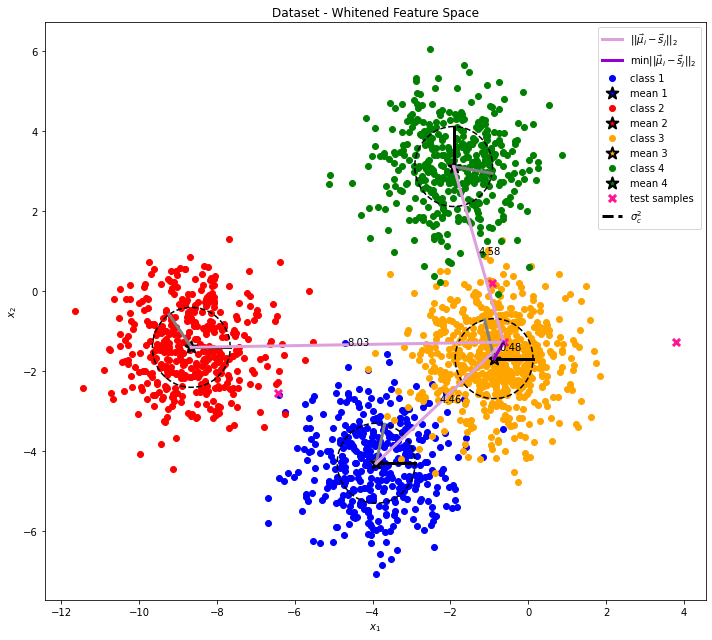

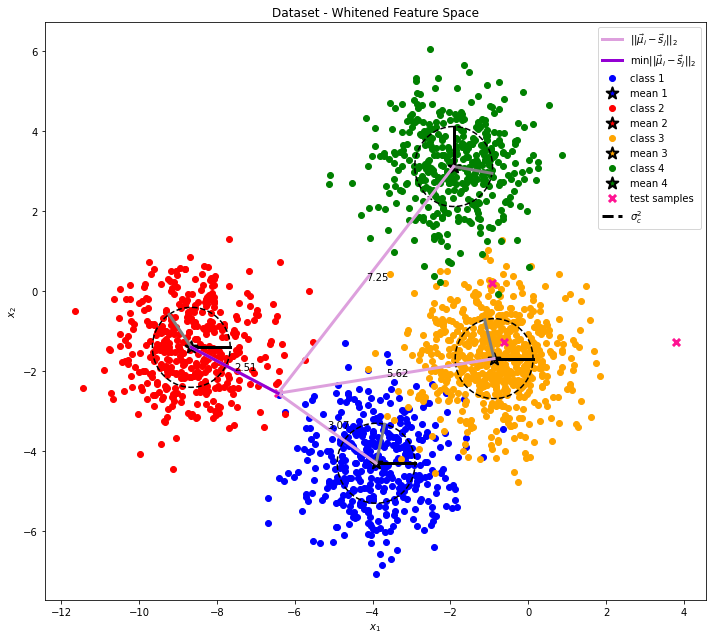

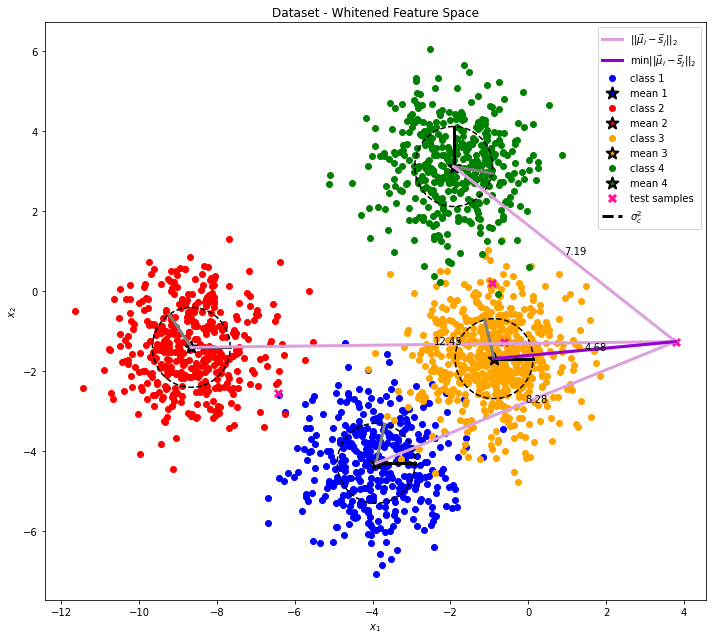

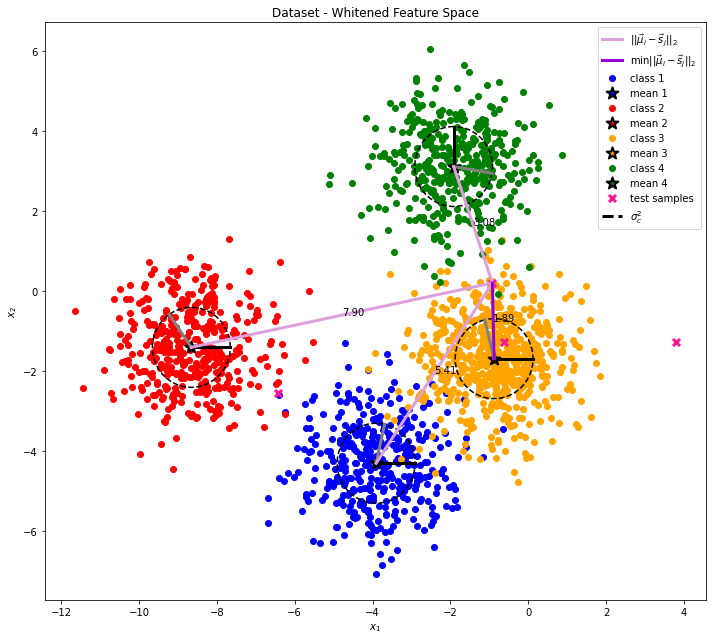

In [257]:
for j in range(J):
    visualize_space(whitened_data, whitened_means, whitened_eigenvalues, whitened_eigenvectors, title="Dataset - Whitened Feature Space", save_name="dataset-whitened_feature_space.png", test_samples=whitened_test_samples, test_index=j, distances=whitened_distances)

In [279]:
# for filling in the report table

print_report_table(whitened_distances.T)

| s1 | 4.4632 | 8.0295 | 0.4800 | 4.5771 | class 3 |
| s2 | 3.0685 | 2.5084 | 5.6202 | 7.2483 | class 2 |
| s3 | 8.2759 | 12.4474 | 4.6832 | 7.1909 | class 3 |
| s4 | 5.4086 | 7.9037 | 1.8926 | 3.0785 | class 3 |


### 2. Repeat questions A.1, A.2 and A.3. but this time using the whitened data and whitened testing samples and report the results in the following table 3:

| Test Samples | d($\mu_1$,$s_j$) | d($\mu_2$,$s_j$) | d($\mu_3$,$s_j$) | d($\mu_4$,$s_j$) | Class Assignment |
|--------------|-------------:|--:|--:|--:|------------------|
| s1 | 4.4632 | 8.0295 | 0.4800 | 4.5771 | class 3 |
| s2 | 3.0685 | 2.5084 | 5.6202 | 7.2483 | class 2 |
| s3 | 8.2759 | 12.4474 | 4.6832 | 7.1909 | class 3 |
| s4 | 5.4086 | 7.9037 | 1.8926 | 3.0785 | class 3 |
<center>Table  3: Euclidean distances and classification results in the whitened space</center>

----------------

## Part C: Original feature space and Mahalanobis distance

### 1. Using the original dataset from Part A (ie. before whitening), repeat question A.3 using the Mahalanobis distances instead of the Euclidean $r(\mu_i, s_j)$ and report the results in the following table 4.

| Test Samples | d($\mu_1$,$s_j$) | d($\mu_2$,$s_j$) | d($\mu_3$,$s_j$) | d($\mu_4$,$s_j$) | Class Assignment |
|--------------|-------------:|--:|--:|--:|------------------|
| | | | | |
<center>Table  4:  Mahalanobis distances and classification results in the original feature space</center>

### 2. Compare Tables 2, 3, 4 and comment on the classification results.

> answer

<hr />

# Report:

### 1. Write and submit a Mini-Project Report 1 containing the answers to all the questions above, including a discussion on the results – i.e. the mean and covariance before and after the whitening; the class assignments in all three cases; etc.

> answer

### 2. Submit your implementations.

> answer